In [2]:
import pandas as pd
import numpy as np
import tqdm

In [2]:
import csv
import os
from tqdm import tqdm  # Progress bar library

# Input and output filenames
input_file = "/home/kk/Codes/Muon_Tomography_Image_Reconstruction/build/muon_hits_output.csv"
output_file = "/home/kk/Codes/Muon_Tomography_Image_Reconstruction/build/processed_grouped_muon_hits.csv"

# Function to count total lines for progress estimation
def count_lines(filename):
    with open(filename, "r") as f:
        return sum(1 for _ in f)

# Function to process the large CSV file
def process_large_csv(input_filename, output_filename):
    total_lines = count_lines(input_filename)  # Get total number of lines
    with open(input_filename, "r") as infile, open(output_filename, "w", newline="") as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)

        # Read and write headers
        header = next(reader)  # Read the header row
        new_header = [f"{col}_strip{i}" for i in range(4) for col in header]  
        writer.writerow(new_header)  # Write new header

        # Variables to store group data
        current_group = {}
        progress_bar = tqdm(reader, total=total_lines, desc="Processing", unit=" rows")

        for row in progress_bar:
            strip_id = int(row[0])  # First column is StripID

            # If this is a new group, reset tracking
            if strip_id == 0:
                if len(current_group) == 4:  # If we already have a full set (0,1,2,3), write to file
                    writer.writerow([val for i in range(4) for val in current_group[i]])
                
                # Reset group storage
                current_group = {}

            # Store valid strip IDs (0,1,2,3)
            if strip_id in {0, 1, 2, 3}:
                current_group[strip_id] = row

        # Write the last valid group if it exists
        if len(current_group) == 4:
            writer.writerow([val for i in range(4) for val in current_group[i]])

    print(f"\nProcessing complete. Output saved to {output_filename}")

# Run the function
process_large_csv(input_file, output_file)


Processing: 100%|█████████▉| 159228387/159228388 [04:45<00:00, 557006.34 rows/s]


Processing complete. Output saved to /home/kk/Codes/Muon_Tomography_Image_Reconstruction/build/processed_grouped_muon_hits.csv


In [1]:
import pandas as pd
import numpy as np

# Path to your processed CSV file
processed_file = "/home/kk/Codes/Muon_Tomography_Image_Reconstruction/build/processed_grouped_muon_hits.csv"

# Read the CSV file
# df = pd.read_csv(processed_file)

In [15]:
import numpy as np
import csv
from tqdm import tqdm

input_file = "/home/kk/Codes/Muon_Tomography_Image_Reconstruction/build/processed_grouped_muon_hits.csv"  # Change to your actual file path
output_file = "/home/kk/Codes/Muon_Tomography_Image_Reconstruction/build/poca_results.csv"

# Read the header to determine column positions
with open(input_file, "r") as f:
    header = next(f).strip().split(",")

# Column indices for required data
idxs = {
    "MuonEnergy_strip1": header.index("MuonEnergy_strip1"),
    "MuonEnergy_strip2": header.index("MuonEnergy_strip2"),
    "PosX_strip0": header.index("PosX_strip0"),
    "PosY_strip0": header.index("PosY_strip0"),
    "PosZ_strip0": header.index("PosZ_strip0"),
    "PosX_strip1": header.index("PosX_strip1"),
    "PosY_strip1": header.index("PosY_strip1"),
    "PosZ_strip1": header.index("PosZ_strip1"),
    "PosX_strip2": header.index("PosX_strip2"),
    "PosY_strip2": header.index("PosY_strip2"),
    "PosZ_strip2": header.index("PosZ_strip2"),
    "PosX_strip3": header.index("PosX_strip3"),
    "PosY_strip3": header.index("PosY_strip3"),
    "PosZ_strip3": header.index("PosZ_strip3"),
}

# Process in chunks
chunk_size = 1000000  # Adjust based on memory
with open(input_file, "r") as infile, open(output_file, "w") as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)
    
    # Skip header in input and write new header to output
    next(reader)
    writer.writerow(["PoCA_X", "PoCA_Y", "PoCA_Z", "Angle", "Energy_loss"])

    batch = []  # Store results before writing in chunks
    for i, row in tqdm(enumerate(reader), desc="Processing Chunks"):
        # Convert to NumPy arrays for faster processing
        p1 = np.array([float(row[idxs["PosX_strip0"]]), float(row[idxs["PosY_strip0"]]), float(row[idxs["PosZ_strip0"]])])
        p2 = np.array([float(row[idxs["PosX_strip1"]]), float(row[idxs["PosY_strip1"]]), float(row[idxs["PosZ_strip1"]])])
        q1 = np.array([float(row[idxs["PosX_strip2"]]), float(row[idxs["PosY_strip2"]]), float(row[idxs["PosZ_strip2"]])])
        q2 = np.array([float(row[idxs["PosX_strip3"]]), float(row[idxs["PosY_strip3"]]), float(row[idxs["PosZ_strip3"]])])

        # Compute PoCA and angle
        poca, angle = POCA_Point([p1, p2], [q1, q2])

        # Compute energy loss
        energy_loss = float(row[idxs["MuonEnergy_strip1"]]) - float(row[idxs["MuonEnergy_strip2"]])

        # Store result
        batch.append([poca[0], poca[1], poca[2], angle, energy_loss])

        # Write in chunks to avoid memory overflow
        if i % chunk_size == 0 and i > 0:
            writer.writerows(batch)
            batch = []

    # Write any remaining results
    if batch:
        writer.writerows(batch)

print("Processing complete! Results saved in 'poca_results.csv'.")


Processing Chunks: 39241057it [26:12, 24959.35it/s]


Processing complete! Results saved in 'poca_results.csv'.


In [12]:
from Lab_3419 import POCA_Point
p1,p2= np.array([1,2,3]),np.array([2,3,4])
q1,q2= np.array([2,3,4]),np.array([3,4,5])
line_1 = [p1, p2]  # Define the first line with two points
line_2 = [q1, q2]  # Define the second line with two points

poca_point, angle = POCA_Point(line_1, line_2)
print("PoCA Point:", poca_point)
print("Angle between lines:", angle)


PoCA Point: [1.5 2.5 3.5]
Angle between lines: 0.0


In [ ]:
df=pd.read_csv()

,StripID_strip0,EnergyDeposited_strip0,MuonEnergy_strip0,PosX_strip0,PosY_strip0,PosZ_strip0,Time_strip0,StripID_strip1,EnergyDeposited_strip1,MuonEnergy_strip1,...,PosY_strip2,PosZ_strip2,Time_strip2,StripID_strip3,EnergyDeposited_strip3,MuonEnergy_strip3,PosX_strip3,PosY_strip3,PosZ_strip3,Time_strip3
0,0,0.002236,3895.73,-164.8900,299.5,75.9324,10.0651,1,0.002108,3895.73,...,-200.5,104.3220,26.8123,3,0.001335,3895.73,-125.2240,-300.5,109.9990,30.1618
1,0,0.001881,3895.74,81.4290,299.5,93.5976,10.0284,1,0.005108,3895.73,...,-200.5,96.3550,26.7145,3,0.002387,3895.73,72.4233,-300.5,96.9047,30.0518
2,0,0.004317,3895.74,51.1655,299.5,-214.1220,10.0379,1,0.002564,3895.73,...,-200.5,-206.9900,26.7399,3,0.001764,3895.73,77.6784,-300.5,-205.5620,30.0803
3,0,0.002321,3895.74,-122.0100,299.5,-73.8751,10.0576,1,0.001467,3895.73,...,-200.5,-87.4179,26.7925,3,0.002938,3895.73,-78.0297,-300.5,-90.1255,30.1395
4,0,0.003008,3895.74,160.5570,299.5,149.0700,10.0371,1,0.002041,3895.73,...,-200.5,152.0650,26.7377,3,0.002520,3895.73,187.0930,-300.5,152.6630,30.0779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9813168,0,0.001712,3895.74,62.2996,299.5,156.6860,10.0645,1,0.001730,3895.73,...,-200.5,177.8780,26.8107,3,0.003239,3895.73,17.1067,-300.5,182.1160,30.1599
9813169,0,0.003025,3895.74,-34.7295,299.5,153.7390,10.0357,1,0.002078,3895.73,...,-200.5,134.6060,26.7342,3,0.001650,3895.73,-44.4261,-300.5,130.7810,30.0738
9813170,0,0.001551,3895.74,27.4125,299.5,-152.6300,10.0476,1,0.000652,3895.74,...,-200.5,-163.4440,26.7657,3,0.001848,3895.73,63.5088,-300.5,-165.6050,30.1093
9813171,0,0.002549,3895.74,-238.2560,299.5,96.3615,10.0396,1,0.002915,3895.73,...,-200.5,119.2530,26.7445,3,0.002607,3895.73,-250.3230,-300.5,123.8300,30.0855


In [23]:
import numpy as np
import pandas as pd
from tqdm import tqdm
# Prepare storage for results
results = []

# Process each row with a progress bar
for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing PoCA"):
    # Extract 3D points
    p1 = np.array([row["PosX_strip0"], row["PosY_strip0"], row["PosZ_strip0"]])
    p2 = np.array([row["PosX_strip1"], row["PosY_strip1"], row["PosZ_strip1"]])
    q1 = np.array([row["PosX_strip2"], row["PosY_strip2"], row["PosZ_strip2"]])
    q2 = np.array([row["PosX_strip3"], row["PosY_strip3"], row["PosZ_strip3"]])

    # Compute PoCA and angle
    poca, angle = POCA_Point([p1, p2], [q1, q2])

    # Compute energy loss
    energy_loss = row["MuonEnergy_strip1"] - row["MuonEnergy_strip2"]

    # Store result
    results.append([poca[0], poca[1], poca[2], angle, energy_loss])

# Convert results to DataFrame
result_df = pd.DataFrame(results, columns=["PoCA_X", "PoCA_Y", "PoCA_Z", "Angle", "Energy_loss"])

# Save results to CSV
result_df.to_csv("/home/kk/Codes/Muon_Tomography_Image_Reconstruction/build/poca_results.csv", index=False)

print("Processing complete! Results saved in 'poca_results.csv'.")


Processing PoCA: 100%|██████████| 9813173/9813173 [14:22<00:00, 11378.93it/s]


Processing complete! Results saved in 'poca_results.csv'.


In [4]:
df_=pd.read_csv("/home/kk/Codes/Muon_Tomography_Image_Reconstruction/build/Cross/poca_results.csv")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar

def Reconstruct (df,resolution=50):
    # Filter data based on conditions
    df_filtered = df[(df["Energy_loss"] > 2.0) & 
    (df["Angle"] > 0.02) & (df["Angle"] < 10) &
    (df["PoCA_Y"] >= -75) &  
    (df["PoCA_Y"] <= 75)]

    # Define grid parameters
    grid_size = 250  # Pixels range from -250 to 250
    num_bins = resolution   # Number of bins in each axis
    x_bins = np.linspace(-grid_size, grid_size, num_bins + 1)
    z_bins = np.linspace(-grid_size, grid_size, num_bins + 1)

    # Create storage for grid values
    energy_grid = np.zeros((num_bins, num_bins))
    angle_grid = np.zeros((num_bins, num_bins))
    count_grid = np.zeros((num_bins, num_bins))  # Stores count for averaging

    # Process data with a progress bar
    for _, row in tqdm(df_filtered.iterrows(), total=df_filtered.shape[0], desc="Processing PoCA data"):
        x, z = row["PoCA_X"], row["PoCA_Z"]
        energy_loss = row["Energy_loss"]
        angle = row["Angle"]

        # Find the pixel index
        x_idx = np.digitize(x, x_bins) - 1
        z_idx = np.digitize(z, z_bins) - 1

        # Ensure within valid range
        if 0 <= x_idx < num_bins and 0 <= z_idx < num_bins:
            # Accumulate values
            energy_grid[x_idx, z_idx] += energy_loss
            angle_grid[x_idx, z_idx] += angle  # Store angle for mean calculation
            count_grid[x_idx, z_idx] += 1

    # Compute mean energy loss and mean angle, handling division by zero
    energy_grid = np.divide(energy_grid, count_grid, where=count_grid > 0)
    angle_grid = np.divide(angle_grid, count_grid, where=count_grid > 0)

    # Replace NaN and inf values with 0
    energy_grid = np.nan_to_num(energy_grid, nan=0.0, posinf=0.0, neginf=0.0)
    angle_grid = np.nan_to_num(angle_grid, nan=0.0, posinf=0.0, neginf=0.0)

    # Clip extreme values to avoid visualization issues
    energy_grid = np.clip(energy_grid, 0, np.percentile(energy_grid, 99))  # Limit extreme values
    angle_grid = np.clip(angle_grid, 0, np.percentile(angle_grid, 99))
    return energy_grid, angle_grid


In [35]:
df = df_[:800000]
energy_grid, angle_grid = Reconstruct(df,500)

Processing PoCA data:   0%|          | 0/121040 [00:00<?, ?it/s]

Processing PoCA data: 100%|██████████| 121040/121040 [00:05<00:00, 23239.21it/s]


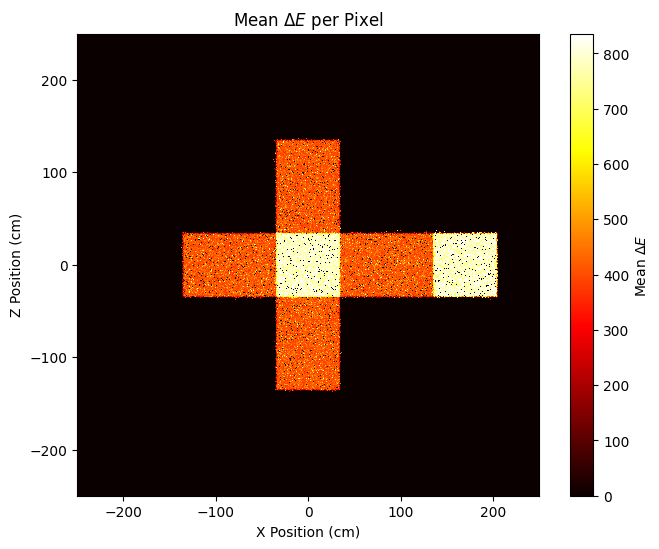

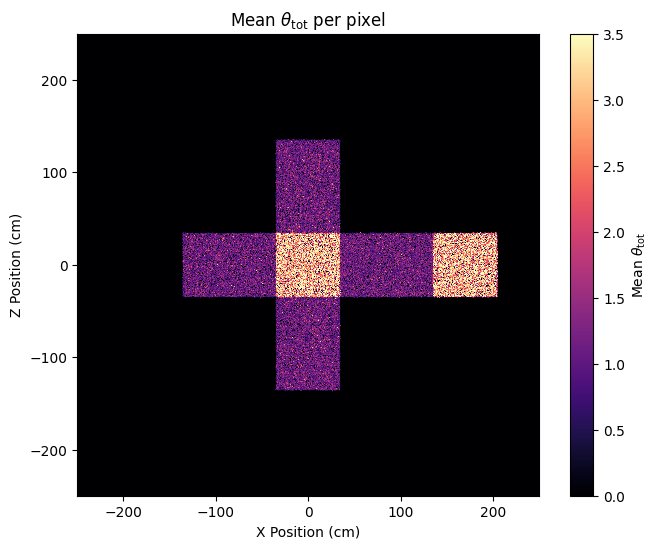

In [36]:

# Plot Energy Loss (Mean)
plt.figure(figsize=(8, 6))
plt.imshow(energy_grid.T, extent=[-250, 250, -250, 250], origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar(label=r"Mean $\Delta E$")
plt.xlabel("X Position (cm)")
plt.ylabel("Z Position (cm)")
plt.title(r"Mean $\Delta E$ per Pixel")
plt.show()

# Plot Mean Angle
plt.figure(figsize=(8, 6))
plt.imshow(angle_grid.T, extent=[-250, 250, -250, 250], origin='lower', cmap='magma', interpolation='nearest')
plt.colorbar(label=r"Mean $\theta_{\text{tot}}$")
plt.xlabel("X Position (cm)")
plt.ylabel("Z Position (cm)")
plt.title(r"Mean $\theta_{\text{tot}}$ per pixel")
plt.show()

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
matplotlib.use("TkAgg")  # Ensure external interactive window

# Define grid parameters
df_filtered = df[(df["Energy_loss"] > 10.0) & 
                 (df["Angle"] > 0.2) & (df["Angle"] < 30) &
                 (df["PoCA_Y"] >= -75) &  
                 (df["PoCA_Y"] <= 75)][:1000000]

grid_size = 250
num_bins = 100
x_bins = np.linspace(-grid_size, grid_size, num_bins + 1)
z_bins = np.linspace(-grid_size, grid_size, num_bins + 1)
y_bins = np.linspace(-75, 75, num_bins + 1)

# Compute bin centers
x_centers = (x_bins[:-1] + x_bins[1:]) / 2
y_centers = (y_bins[:-1] + y_bins[1:]) / 2
z_centers = (z_bins[:-1] + z_bins[1:]) / 2

# Create storage for 3D grid values
energy_grid = np.zeros((num_bins, num_bins, num_bins))
angle_grid = np.zeros((num_bins, num_bins, num_bins))
count_grid = np.zeros((num_bins, num_bins, num_bins))

# Process data
for _, row in tqdm(df_filtered.iterrows(), total=df_filtered.shape[0], desc="Processing 3D PoCA data"):
    x, z, y = row["PoCA_X"], row["PoCA_Z"], row["PoCA_Y"]
    energy_loss = row["Energy_loss"]
    angle = row["Angle"]

    # Find pixel index
    x_idx = np.digitize(x, x_bins) - 1
    y_idx = np.digitize(y, y_bins) - 1
    z_idx = np.digitize(z, z_bins) - 1

    if (0 <= x_idx < num_bins) and (0 <= y_idx < num_bins) and (0 <= z_idx < num_bins):
        energy_grid[x_idx, y_idx, z_idx] += energy_loss
        angle_grid[x_idx, y_idx, z_idx] += angle
        count_grid[x_idx, y_idx, z_idx] += 1

# Apply threshold: Keep only voxels with count > 20
valid_voxels = count_grid > 5

# Compute mean values
energy_grid[valid_voxels] = np.divide(energy_grid[valid_voxels], count_grid[valid_voxels])
angle_grid[valid_voxels] = np.divide(angle_grid[valid_voxels], count_grid[valid_voxels])

# Extract valid voxel coordinates
x_idx, y_idx, z_idx = np.where(valid_voxels)
x_vals = x_centers[x_idx]
y_vals = y_centers[y_idx]
z_vals = z_centers[z_idx]
energy_vals = energy_grid[x_idx, y_idx, z_idx]
angle_vals = angle_grid[x_idx, y_idx, z_idx]



Processing 3D PoCA data: 100%|██████████| 1000000/1000000 [00:47<00:00, 20972.79it/s]


In [32]:
# 3D Visualization for Energy Loss
plt.ion()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x_vals, z_vals, y_vals, c=energy_vals, cmap='hot', s=2)

# Labels
ax.set_xlabel("X Axis (cm)")
ax.set_ylabel("Z Axis (cm)")  # Flipped
ax.set_zlabel("Y Axis (cm)")
ax.set_title(r"3d Reconstruction using $\Delta E$ mean")

# Set axis limits
ax.set_xlim(-250, 250)
ax.set_ylim(-250, 250)
ax.set_zlim(-75, 75)

# Show colorbar
cb = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cb.set_label(r"$\Delta E$ mean (MeV)")

# Show in external window
plt.show(block=True)

# Keep plot open
plt.pause(0.1)


In [31]:
# 3D Visualization for Scattering Angle
plt.ion()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x_vals, z_vals, y_vals, c=angle_vals, cmap='magma', s=2)

# Labels
ax.set_xlabel("X Axis (cm)")
ax.set_ylabel("Z Axis (cm)")  # Flipped
ax.set_zlabel("Y Axis (cm)")
ax.set_title(r"3D Reconstruction using $\theta_{\text{tot}}$ mean")

# Set axis limits
ax.set_xlim(-250, 250)
ax.set_ylim(-250, 250)
ax.set_zlim(-75, 75)

# Show colorbar
cb = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cb.set_label(r"$\theta_{\text{tot}}$ mean (deg)")

# Show in external window
plt.show(block=True)

# Keep plot open
plt.pause(0.1)


# MLP
____________________________________

In [31]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Define grid creation
def create_grid(nx, ny, nz, X, Y, Z):
    x_edges = np.linspace(-X, X, nx + 1)
    y_edges = np.linspace(-Y, Y, ny + 1)
    z_edges = np.linspace(-Z, Z, nz + 1)
    return x_edges, y_edges, z_edges

# Assign position to voxel index
def get_voxel_index(x, y, z, x_edges, y_edges, z_edges):
    ix = np.searchsorted(x_edges, x, side='right') - 1
    iy = np.searchsorted(y_edges, y, side='right') - 1
    iz = np.searchsorted(z_edges, z, side='right') - 1
    if 0 <= ix < len(x_edges)-1 and 0 <= iy < len(y_edges)-1 and 0 <= iz < len(z_edges)-1:
        return ix, iy, iz
    return None

# Load and process data
def process_muon_data(filepath, nx, ny, nz, X, Y, Z):
    data = pd.read_csv(filepath)

    # Create grid
    x_edges, y_edges, z_edges = create_grid(nx, ny, nz, X, Y, Z)
    energy_grid = np.zeros((nx, ny, nz))
    angle_grid = np.zeros((nx, ny, nz))
    energy_counts = np.zeros((nx, ny, nz))
    angle_counts = np.zeros((nx, ny, nz))

    # Iterate through each row with tqdm
    for i in tqdm(range(1, len(data) - 1)):
        row_prev = data.iloc[i - 1]
        row = data.iloc[i]
        row_next = data.iloc[i + 1]

        # Accumulate energy deposition
        voxel = get_voxel_index(row.PosX, row.PosY, row.PosZ, x_edges, y_edges, z_edges)
        if voxel:
            ix, iy, iz = voxel
            energy_grid[ix, iy, iz] += row.EnergyDeposited
            energy_counts[ix, iy, iz] += 1

            # Time condition for angle calculation
            if row_prev.Time < row.Time < row_next.Time:
                # Create vectors
                vec1 = np.array([row.PosX - row_prev.PosX,
                                 row.PosY - row_prev.PosY,
                                 row.PosZ - row_prev.PosZ])
                vec2 = np.array([row_next.PosX - row.PosX,
                                 row_next.PosY - row.PosY,
                                 row_next.PosZ - row.PosZ])
                # Compute angle between vectors
                norm1 = np.linalg.norm(vec1)
                norm2 = np.linalg.norm(vec2)
                if norm1 > 0 and norm2 > 0:
                    cos_theta = np.dot(vec1, vec2) / (norm1 * norm2)
                    cos_theta = np.clip(cos_theta, -1.0, 1.0)
                    angle = np.arccos(cos_theta)
                    if angle >=0.8:
                        continue
                    angle_grid[ix, iy, iz] += angle
                    angle_counts[ix, iy, iz] += 1

    # Compute average energy and angle
    avg_energy = np.divide(energy_grid, energy_counts, out=np.zeros_like(energy_grid), where=energy_counts != 0)
    avg_angle = np.divide(angle_grid, angle_counts, out=np.zeros_like(angle_grid), where=angle_counts != 0)

    return avg_energy, avg_angle, x_edges, y_edges, z_edges



In [34]:
E,θ,X,Y,Z = process_muon_data("/home/kk/Codes/Muon_Tomography_Image_Reconstruction_MLP/build/muon_hits_output.csv",200,200,100,300,300,150)

100%|██████████| 19537357/19537357 [45:29<00:00, 7157.18it/s]


In [35]:
np.savez("/home/kk/Codes/Muon_Tomography_Image_Reconstruction_MLP/build/grids_output.npz", E=E, theta=θ, X=X, Y=Y, Z=Z)


In [96]:
import matplotlib.pyplot as plt
import numpy as np

def project_to_xy(grid):
    """
    Project 3D grid onto XY plane by summing over Z axis.
    """
    return np.mean(grid, axis=2)  # shape (nx, ny)

def plot_2d_projection(E, θ, X, Y,v2=1):
    """
    Plot 2D projections of Energy and Angle grids on XY plane.
    """
    E_proj = project_to_xy(E)
    θ_proj = project_to_xy(θ)

    extent = [X[0], X[-1], Y[0], Y[-1]]  # for imshow

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(E_proj.T, origin='lower', extent=extent, cmap='inferno', aspect='auto')
    plt.colorbar(label='Average Energy Lost per pixel (MeV)')
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.title('Energy Loss Projection on XZ plane')

    plt.subplot(1, 2, 2)
    plt.imshow(θ_proj.T, origin='lower', extent=extent, cmap='inferno',vmax=v2, aspect='auto')
    plt.colorbar(label='Average Scattering Angle per pixel (rad)')
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.title('Scattering Angle Projection on XZ plane')

    plt.tight_layout()
    plt.show()

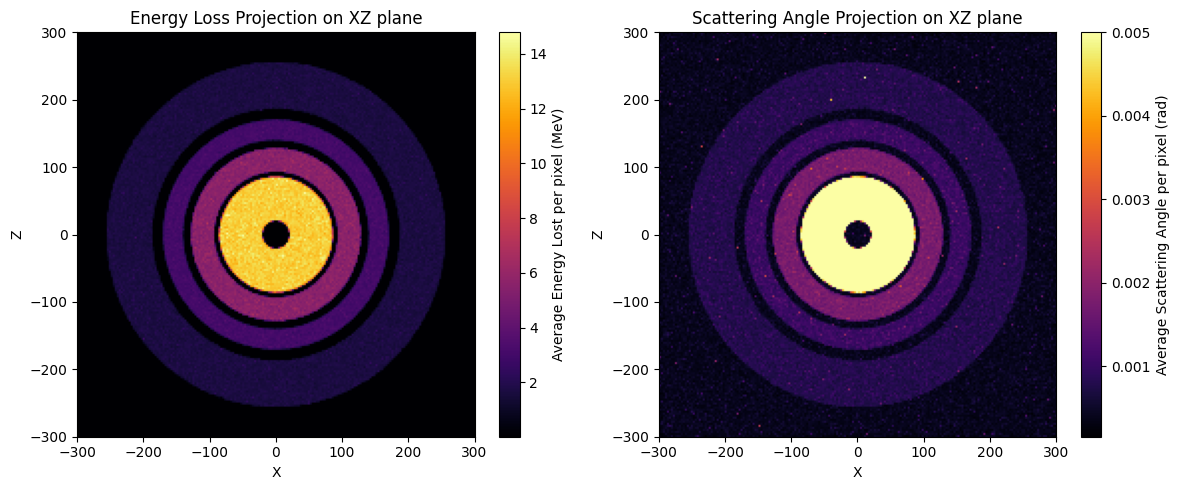

In [97]:
plot_2d_projection(E, θ, X, Y,0.005) 

In [109]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def interactive_3d_plot(grid, X, Y, Z, title, threshold=0.01, cmap_name='inferno', min_alpha=0.05, elev=30, azim=45,vm=100):
    """
    Fast interactive 3D scatter plot with real values, transparency, and view rotation.
    
    Args:
        grid: 3D numpy array (nx, ny, nz)
        X, Y, Z: 1D arrays for voxel boundaries
        title: Plot title
        threshold: Minimum raw value to include
        cmap_name: Matplotlib colormap name
        min_alpha: Transparency for lowest visible points
        elev: Elevation angle in the z plane (degrees)
        azim: Azimuthal angle in the x-y plane (degrees)
    """
    plt.ion()

    mask = grid > threshold
    if np.sum(mask) == 0:
        print("No voxels exceed threshold.")
        return

    # Centers of the voxels
    x_centers = (X[:-1] + X[1:]) / 2
    y_centers = (Y[:-1] + Y[1:]) / 2
    z_centers = (Z[:-1] + Z[1:]) / 2
    Xc, Yc, Zc = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')

    # Masked values
    x_vals = Xc[mask].flatten()
    y_vals = Yc[mask].flatten()
    z_vals = Zc[mask].flatten()
    values = grid[mask].flatten()

    # Color mapping and transparency
    vmin, vmax = np.min(values), np.max(values)
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(cmap_name)
    colors = cmap(norm(values))
    alphas = min_alpha + (1 - min_alpha) * ((values - vmin) / (vmax - vmin + 1e-9))
    colors[:, 3] = alphas

    # Plotting
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x_vals, y_vals, z_vals, c=values, cmap=cmap_name,vmax=vm, alpha=1, s=5)

    ax.set_xlim([X[0], X[-1]])
    ax.set_ylim([Y[0], Y[-1]])
    ax.set_zlim([Z[0], Z[-1]])
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Z (cm)')
    ax.set_zlabel('Y (cm)')
    ax.set_title(title)

    # Apply initial view rotation
    ax.view_init(elev=elev, azim=azim)

    fig.colorbar(scatter, ax=ax, label='Value')
    plt.tight_layout()
    plt.show()


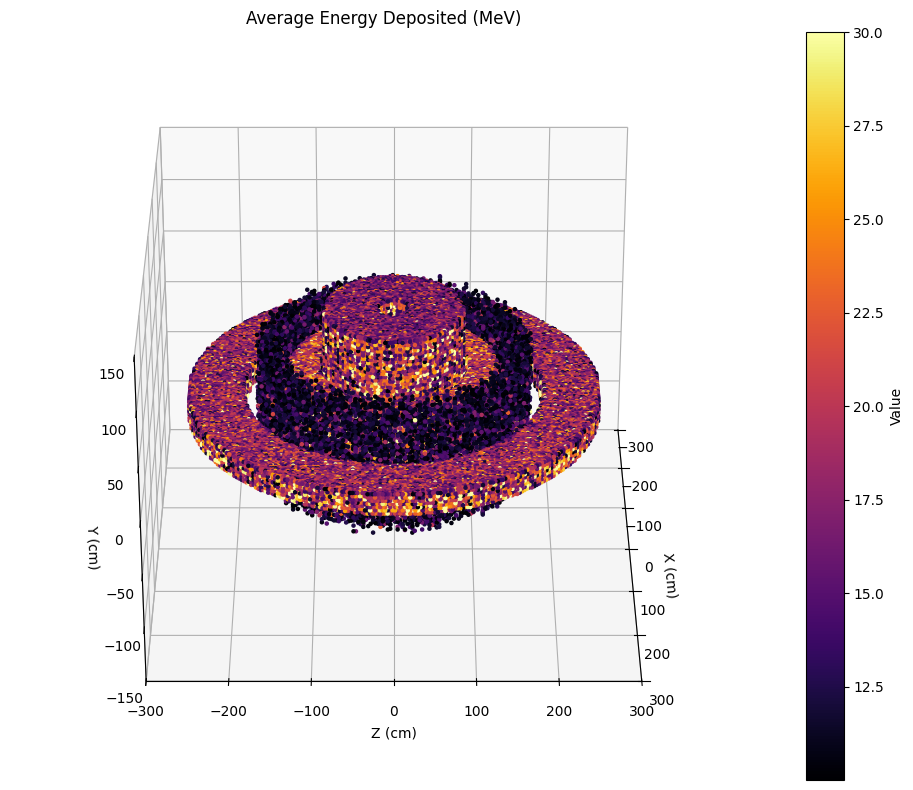

In [112]:
interactive_3d_plot(E, X, Y, Z, "Average Energy Deposited (MeV)", threshold=10, elev=30, azim=0,vm=30)

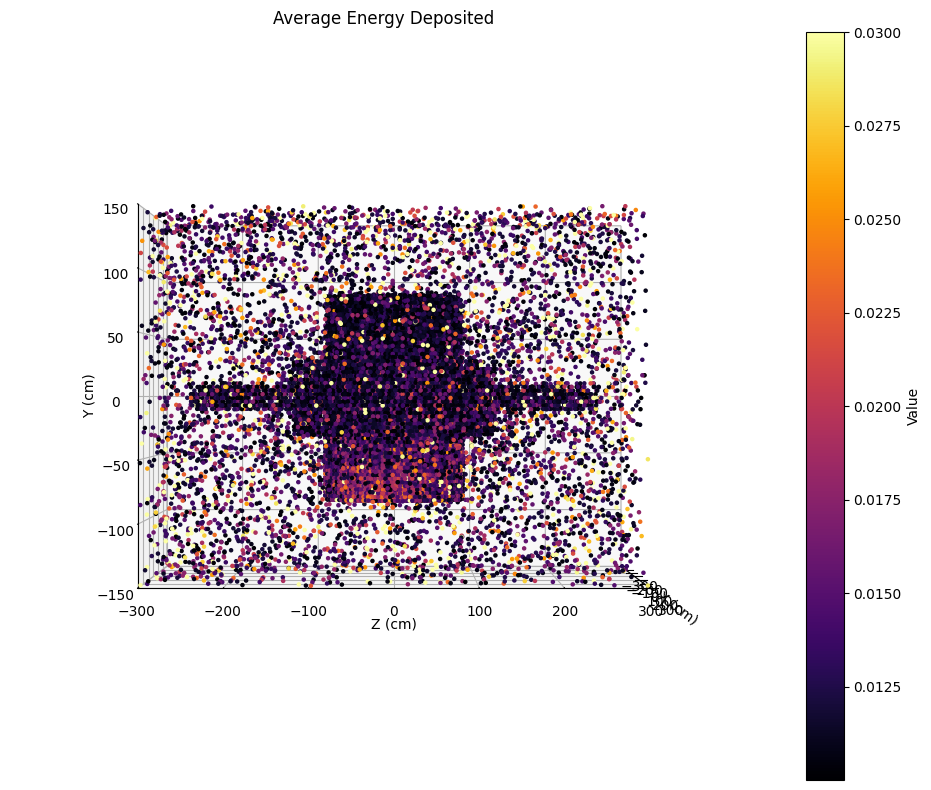

In [113]:
interactive_3d_plot(θ, X, Y, Z, "Average Energy Deposited", threshold=0.01, elev=0, azim=0,vm=0.03)